In [4]:
%matplotlib widget
import multiprocessing
import time
import starepandas
import glob
import pandas
import sqlalchemy
import numpy
import matplotlib.pyplot as plt
import modreaders
import pickle
from itertools import repeat
import contextily
import pystare
import postgis
import geopandas
import dask

In [2]:
starepandas.__version__

'0.6.3'

# Load data

<AxesSubplot: >

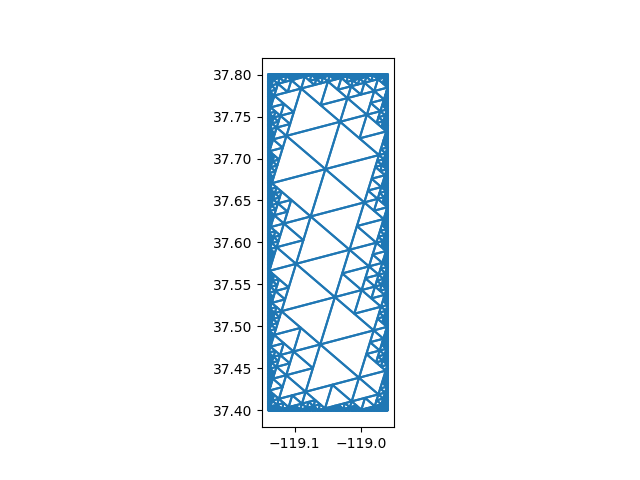

In [8]:
with open('data/roi_4326_buffer_huge.pickle', 'rb') as f:
    roi = pickle.load(f)
roi_sids = roi.sids.iloc[0]
roi.plot()

## VIIRS

In [ ]:
%%time
# We have to read in batches because of memory limits

n_processes = 62

def read_batch(file_paths):
    with multiprocessing.Pool(processes=n_processes) as pool:
        vnp09 = pool.starmap(modreaders.read_vnp09, zip(file_paths, repeat(roi_sids)))
    vnp09 = pandas.concat(vnp09)
    vnp09.reset_index(drop=True, inplace=True)
    return vnp09

file_paths = glob.glob('/tablespace/spires/vnp09/VNP09*.hdf')#[0:120]

vnp09 = []
for file_batch in numpy.array_split(file_paths, round(len(file_paths)/n_processes)):    
    vnp09.append(read_batch(file_batch))
    
vnp09 = pandas.concat(vnp09)
vnp09.reset_index(drop=True, inplace=True)

In [8]:
with open('/tablespace/spires/vnp09.pickle', 'wb') as f:
    pickle.dump(vnp09, f)

In [3]:
%%time
# We have to read in batches because of memory limits

n_processes = 64

def read_batch(file_paths):
    with multiprocessing.Pool(processes=n_processes) as pool:
        mod09 = pool.starmap(modreaders.read_mod09, zip(file_paths, repeat(roi_sids)))
    mod09 = pandas.concat(mod09)
    mod09.reset_index(drop=True, inplace=True)
    return mod09

file_paths = glob.glob('/tablespace/spires/mod09/MOD09*.hdf')#[0:120]

mod09 = []
for file_batch in numpy.array_split(file_paths, round(len(file_paths)/n_processes)):    
    mod09.append(read_batch(file_batch))
    
mod09 = pandas.concat(mod09)
mod09.reset_index(drop=True, inplace=True)

CPU times: user 4min 11s, sys: 15min 13s, total: 19min 25s
Wall time: 8h 3min 32s


In [4]:
mod09.info()

<class 'starepandas.staredataframe.STAREDataFrame'>
RangeIndex: 15636747 entries, 0 to 15636746
Data columns (total 35 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   index                            int64         
 1   lat                              float32       
 2   lon                              float32       
 3   sids                             int64         
 4   ts_start                         datetime64[ns]
 5   ts_end                           datetime64[ns]
 6   scan_pos                         uint16        
 7   track_pos                        uint16        
 8   500m Surface Reflectance Band 1  float64       
 9   500m Surface Reflectance Band 2  float64       
 10  500m Surface Reflectance Band 3  float64       
 11  500m Surface Reflectance Band 4  float64       
 12  500m Surface Reflectance Band 5  float64       
 13  500m Surface Reflectance Band 6  float64       
 14  500m Surface Refle

# Save

In [5]:
with open('/tablespace/spires/mod09.pickle', 'wb') as f:
    pickle.dump(mod09, f)

In [5]:
with open('/tablespace/spires/mod09.pickle', 'rb') as f:
    mod09 = pickle.load(f)

# Some visualization

In [23]:
p = mod09.groupby('sids17').count()[['lat']].reset_index()
p.set_sids('sids17', inplace=True)
trixels = p.make_trixels(n_partitions=64)
p.set_trixels(trixels, inplace=True)
p.set_geometry('trixels', inplace=True)

In [24]:
p = p[p.stare_intersects(roi.sids.iloc[0])]

In [25]:
print(p.lat.min(), p.lat.max())

60 154


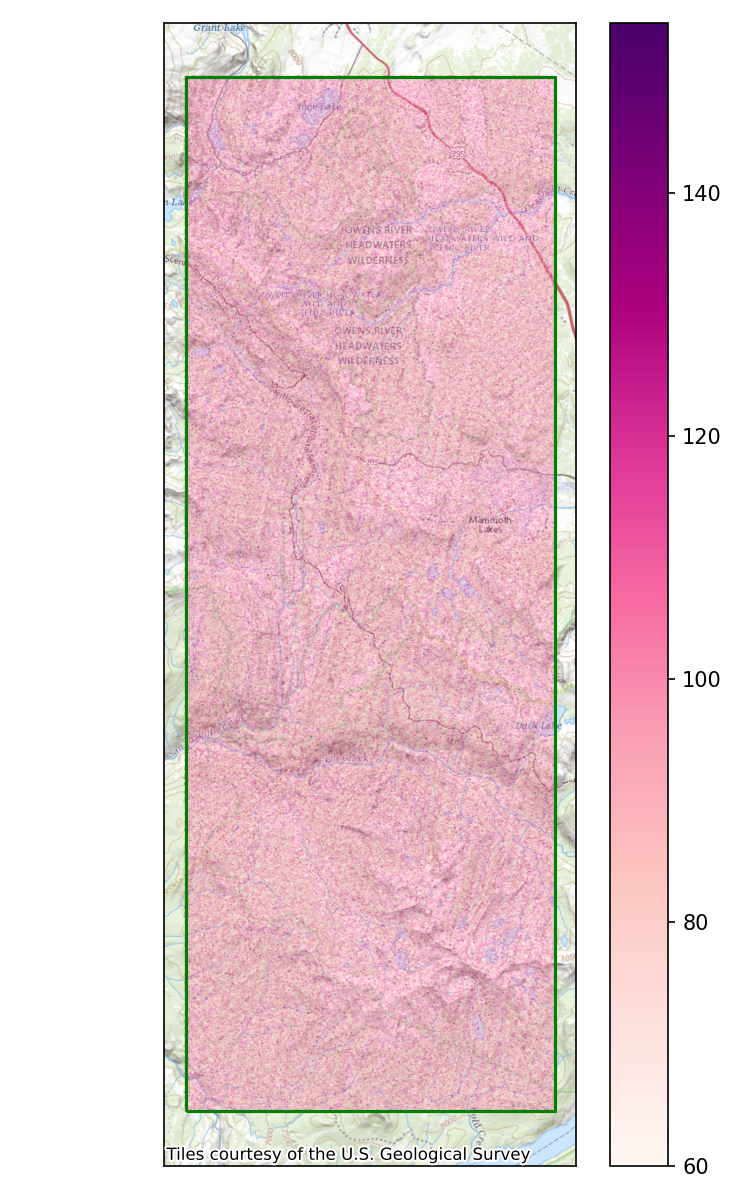

In [26]:
fig = plt.figure(figsize=(5, 8), dpi=150)
ax = fig.add_subplot()

p.to_crs(epsg=3857).plot(ax=ax, zorder=1, linewidth=0.2, column='lat', legend=True, cmap='RdPu', boundary=False, alpha=0.5)
roi.to_crs(epsg=3857).exterior.plot(ax=ax, color='g', zorder=1)
contextily.add_basemap(ax, source=contextily.providers.USGS.USTopo)
plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
fig.tight_layout()

# Upload

In [11]:
user = 'spires_rw'
pwd = 'spiresrw'
host= 'localhost'
db_name = 'spires'
uri = f'postgresql+psycopg2://{user}:{pwd}@{host}/{db_name}'

engine = sqlalchemy.create_engine(uri)

In [13]:
mod09.set_geometry('center_point').to_postgis('mod09', con=engine, if_exists='replace', index=False, chunksize=10000)

In [31]:
with engine.connect() as con:
    con.execute('CREATE INDEX IF NOT EXISTS sids14 ON public.mod09 USING btree (sids14 ASC NULLS LAST) TABLESPACE ts;')
    con.execute('CREATE INDEX IF NOT EXISTS sids15 ON public.mod09 USING btree (sids15 ASC NULLS LAST) TABLESPACE ts;')
    con.execute('CREATE INDEX IF NOT EXISTS sids16 ON public.mod09 USING btree (sids16 ASC NULLS LAST) TABLESPACE ts;')
    con.execute('CREATE INDEX IF NOT EXISTS sids17 ON public.mod09 USING btree (sids17 ASC NULLS LAST) TABLESPACE ts;')
    con.execute('CREATE INDEX IF NOT EXISTS sids18 ON public.mod09 USING btree (sids18 ASC NULLS LAST) TABLESPACE ts;')

In [ ]:
pandas.read_sql('SELECT sids17, count(*) FROM mod09 GROUP BY sids17;', con=engine).min()

## Fast upload for large Datasets

In [21]:
import csv
from io import StringIO

def psql_insert_copy(table, conn, keys, data_iter):
    """
    Execute SQL statement inserting data

    Parameters
    ----------
    table : pandas.io.sql.SQLTable
    conn : sqlalchemy.engine.Engine or sqlalchemy.engine.Connection
    keys : list of str
        Column names
    data_iter : Iterable that iterates the values to be inserted
    """
    # gets a DBAPI connection that can provide a cursor
    dbapi_conn = conn.connection
    with dbapi_conn.cursor() as cur:
        s_buf = StringIO()
        writer = csv.writer(s_buf)
        writer.writerows(data_iter)
        s_buf.seek(0)

        columns = ', '.join(['"{}"'.format(k) for k in keys])
        if table.schema:
            table_name = '{}.{}'.format(table.schema, table.name)
        else:
            table_name = table.name

        sql = 'COPY {} ({}) FROM STDIN WITH CSV'.format(table_name, columns)
        cur.copy_expert(sql=sql, file=s_buf)
        #s_buf.close()

In [22]:
start = time.time()
mod09[0:1].to_sql('r0', con=engine, if_exists='replace', index=False)
for chunk in numpy.array_split(mod09, 1000):
    chunk.to_sql('r0', con=engine, if_exists='append', 
                 method=psql_insert_copy, chunksize=1000000, index=False)
print(time.time() - start)

ProgrammingError: (psycopg2.ProgrammingError) can't adapt type 'Point'
[SQL: INSERT INTO r0 (lat, lon, sids, ts_start, ts_end, x, y, "500m Surface Reflectance Band 1", "500m Surface Reflectance Band 2", "500m Surface Reflectance Band 3", "500m Surface Reflectance Band 4", "500m Surface Reflectance Band 5", "500m Surface Reflectance Band 6", "500m Surface Reflectance Band 7", "500m Reflectance Band Quality", "1km Reflectance Data State QA", cloud, cloud_shadow, cloud_internal, snow_mod35, snow_internal, "SensorAzimuth", "SensorZenith", "SolarAzimuth", "SolarZenith", sids14, sids15, sids16, sids17, sids18, center_points, area, level, ellipse_sids, circle_sids) VALUES (%(lat)s, %(lon)s, %(sids)s, %(ts_start)s, %(ts_end)s, %(x)s, %(y)s, %(500m Surface Reflectance Band 1)s, %(500m Surface Reflectance Band 2)s, %(500m Surface Reflectance Band 3)s, %(500m Surface Reflectance Band 4)s, %(500m Surface Reflectance Band 5)s, %(500m Surface Reflectance Band 6)s, %(500m Surface Reflectance Band 7)s, %(500m Reflectance Band Quality)s, %(1km Reflectance Data State QA)s, %(cloud)s, %(cloud_shadow)s, %(cloud_internal)s, %(snow_mod35)s, %(snow_internal)s, %(SensorAzimuth)s, %(SensorZenith)s, %(SolarAzimuth)s, %(SolarZenith)s, %(sids14)s, %(sids15)s, %(sids16)s, %(sids17)s, %(sids18)s, %(center_points)s, %(area)s, %(level)s, %(ellipse_sids)s, %(circle_sids)s)]
[parameters: {'lat': 37.707706451416016, 'lon': -119.12262725830078, 'sids': 3330895798994382637, 'ts_start': datetime.datetime(2017, 3, 19, 18, 5), 'ts_end': datetime.datetime(2017, 3, 19, 18, 10), 'x': 98, 'y': 2578, '500m Surface Reflectance Band 1': 0.4388, '500m Surface Reflectance Band 2': 0.4715, '500m Surface Reflectance Band 3': 0.4493, '500m Surface Reflectance Band 4': 0.4508, '500m Surface Reflectance Band 5': 0.2541, '500m Surface Reflectance Band 6': 0.1479, '500m Surface Reflectance Band 7': 0.0892, '500m Reflectance Band Quality': 1073741824, '1km Reflectance Data State QA': 1041, 'cloud': 1, 'cloud_shadow': False, 'cloud_internal': True, 'snow_mod35': False, 'snow_internal': False, 'SensorAzimuth': 93.42, 'SensorZenith': 59.7, 'SolarAzimuth': 138.03, 'SolarZenith': 46.43, 'sids14': 3330895797603532814, 'sids15': 3330895798677274639, 'sids16': 3330895798945710096, 'sids17': 3330895798979264529, 'sids18': 3330895798987653138, 'center_points': <shapely.geometry.point.Point object at 0x7f7ac90f6980>, 'area': 1.2779454858774626, 'level': 13, 'ellipse_sids': array([3330895799751016462, 3330895801898500110, 3330895798140403727, ...,
       3330896190171512851, 3330896190358159379, 3330896190492377107]), 'circle_sids': array([3330895798677274639, 3330895799214145551, 3330895802972241935,
       3330895795992920080, 3330895796127137808, 3330895796395573264,
       333 ... (11208 characters truncated) ... 24749331, 3330896172326846483, 3330896172328943635,
       3330896172331040787, 3330896172333137939, 3330896172335235091,
       3330896172337332243])}]
(Background on this error at: https://sqlalche.me/e/14/f405)